In [ ]:
import cv2
import requests
from PIL import Image
import matplotlib.pyplot as plt

import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

## Load image

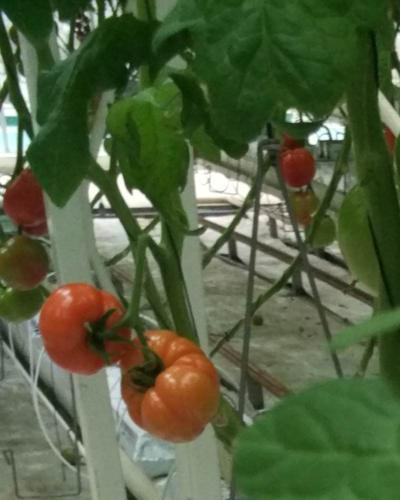

In [3]:
img_path = "./datasets/Tomato detection/Tomato detection/img/tomato0.png"
image = Image.open(img_path)
image

## Load model

Next, let's load the model and its processor from the [hub](https://huggingface.co/CIDAS/clipseg-rd64-refined).

In [4]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

Downloading: 100%|██████████| 974/974 [00:00<00:00, 1.39MB/s]
Downloading: 100%|██████████| 1.06M/1.06M [00:00<00:00, 2.47MB/s]
Downloading: 100%|██████████| 525k/525k [00:00<00:00, 1.96MB/s]
Downloading: 100%|██████████| 472/472 [00:00<00:00, 794kB/s]
Downloading: 100%|██████████| 4.73k/4.73k [00:00<00:00, 2.61MB/s]
Downloading: 100%|██████████| 603M/603M [00:08<00:00, 72.9MB/s] 


## Prepare image and texts for model

The image and a few prompts can be prepared for the model using the processor.

In [5]:
prompts = ["tomato", "flower", "leaf", "stem"]

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

## Forward pass

Next, let's run a forward pass and visualize the predictions the model made.

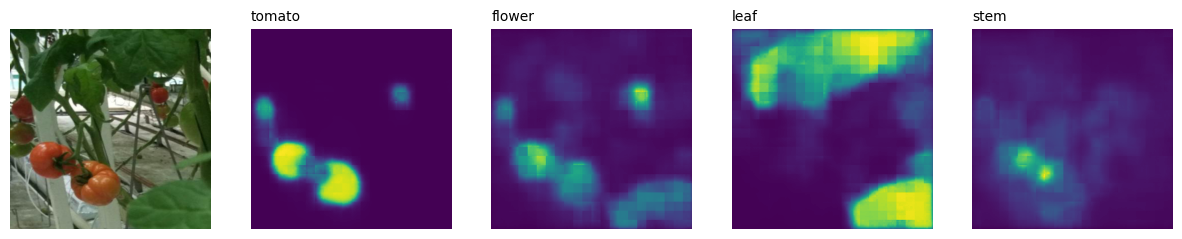

In [6]:
# predict
with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits.unsqueeze(1)

# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image.resize((352, 352)))
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(4)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(4)];

As can be seen, the model is capable of segmenting images based on text prompts in a zero-shot manner. Pretty cool, huh?

## Convert to binary mask

In [7]:
filename = f"./results/mask.png"
# here we save the mask
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [8]:
img2 = cv2.imread(filename)

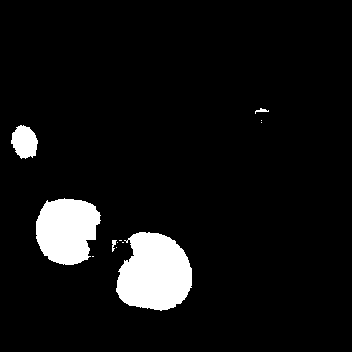

In [9]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

## Another option is to run a single function

In [10]:
def create_seg_mask(input_img, prompts):

    processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
    model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

    inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

    # predict
    with torch.no_grad():
        outputs = model(**inputs)

    preds = outputs.logits.unsqueeze(1)

    # visualize prediction
    _, ax = plt.subplots(1, 5, figsize=(15, len(prompts)))
    [a.axis('off') for a in ax.flatten()]
    ax[0].imshow(image.resize((352, 352)))
    [ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
    [ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

    return [torch.sigmoid(preds[i][0]) for i in range(len(prompts))]

In [11]:
img_path = "./datasets/Tomato detection/Tomato detection/img/tomato0.png"
image = Image.open(img_path)
prompts = ["tomato", "flower", "leaf", "stem"]

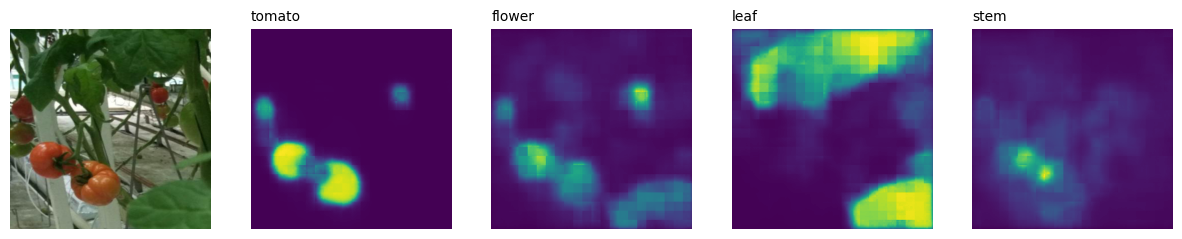

In [12]:
masks_per_class = create_seg_mask(image, prompts)

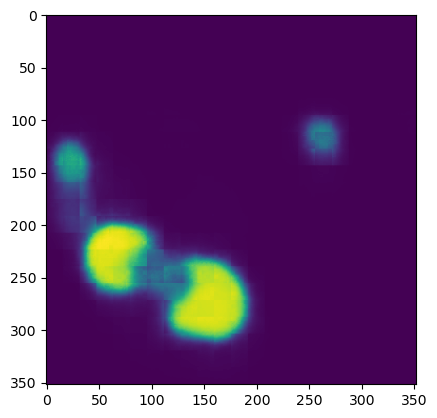

In [13]:
plt.imshow(masks_per_class[0])